In [1]:
f = open("../api_key.txt", "r")
api_key = f.readline()

In [2]:
import requests
import json
from os.path import exists
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

from data_manager import *
from data_visualizer import *

In [3]:
data = grab_daily_data('DIS', api_key)
df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
df = df.drop(labels='5. volume', axis=1)
df = df.sort_index()
df = df.astype(float)
df['Target'] = df['4. close'].astype(float).shift(-1)
df = df.dropna()
df.head(n=15)
# scaler = MinMaxScaler()
# scaler = scaler.fit(df)
# arr = scaler.transform(df)
# df = pd.DataFrame(arr, columns=['open', 'high', 'low', 'close', 'target'])

,1. open,2. high,3. low,4. close,Target
1999-11-01,25.31,26.06,24.94,25.69,26.25
1999-11-02,25.56,26.31,25.50,26.25,26.88
1999-11-03,27.38,27.38,26.69,26.88,26.50
1999-11-04,27.75,29.00,26.00,26.50,24.31
1999-11-05,25.50,25.50,24.06,24.31,23.50
1999-11-08,23.94,24.25,23.38,23.50,23.63
1999-11-09,23.56,24.13,23.50,23.63,23.88
1999-11-10,23.56,24.19,23.50,23.88,24.31
1999-11-11,24.06,24.38,23.44,24.31,25.06
1999-11-12,24.50,26.06,24.06,25.06,25.88


In [12]:
x, y = preprocess_data_rnn('DIS', api_key, lookback=10, lookfront=5, normalize=False)
print(x[0])
print(y[0])

[[25.31 26.06 24.94 25.69]
 [25.56 26.31 25.5  26.25]
 [27.38 27.38 26.69 26.88]
 [27.75 29.   26.   26.5 ]
 [25.5  25.5  24.06 24.31]
 [23.94 24.25 23.38 23.5 ]
 [23.56 24.13 23.5  23.63]
 [23.56 24.19 23.5  23.88]
 [24.06 24.38 23.44 24.31]
 [24.5  26.06 24.06 25.06]]
[27.25]


In [17]:
def get_compiled_model():
    lstm_input = keras.Input(shape=(10,4), name="lstm_input")
    inputs = layers.LSTM(128, name="lstm_layer")(lstm_input)
    inputs = layers.Dense(128, name="dense_layer_1")(inputs)
    inputs = layers.Dense(1, name="dense_layer_2")(inputs)
    output = layers.Activation('linear', name='output')(inputs)
    model = keras.Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [15]:
def train_model(symbol, model, api_key, epochs=30):
    x, y = preprocess_data_rnn(symbol, api_key, lookback=10, lookfront=5, normalize=False)
    model.fit(np.asarray(x), np.asarray(y), epochs=epochs, batch_size=128, shuffle=True, validation_split=0.3)
    return model

In [33]:
def predict_and_save(symbol, api_key, model, save=True):
    x, y = preprocess_data_rnn(symbol, api_key, lookback=10, lookfront=5, normalize=False)
    pred = model.predict(np.asarray(x))
    plt.plot(np.reshape(y, (len(y))))
    plt.plot(np.reshape(pred, (len(pred))))
    print(len(y))
    print(len(pred))
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    if save:
        my_dict = {str(i): str(pred[i][0]) for i in range(0, len(pred))}
        with open("../data/" + symbol + "_pred_rnn_weekly.json", "w") as output_file:
            json.dump(my_dict, output_file)

In [25]:
model = get_compiled_model()
train_model('IBM', model, api_key, epochs=20)

Epoch 1/20
32/32 [==============================] - 2s 29ms/step - loss: 14047.7129 - val_loss: 10297.8223
Epoch 2/20
32/32 [==============================] - 1s 17ms/step - loss: 4304.8706 - val_loss: 556.3793
Epoch 3/20
32/32 [==============================] - 1s 18ms/step - loss: 1649.2174 - val_loss: 401.3977
Epoch 4/20
32/32 [==============================] - 1s 17ms/step - loss: 1052.9996 - val_loss: 134.3442
Epoch 5/20
32/32 [==============================] - 1s 18ms/step - loss: 262.8651 - val_loss: 30.7526
Epoch 6/20
32/32 [==============================] - 1s 18ms/step - loss: 44.9997 - val_loss: 33.0886
Epoch 7/20
32/32 [==============================] - 1s 19ms/step - loss: 28.5353 - val_loss: 25.5002
Epoch 8/20
32/32 [==============================] - 1s 17ms/step - loss: 25.8947 - val_loss: 26.3598
Epoch 9/20
32/32 [==============================] - 1s 19ms/step - loss: 24.9796 - val_loss: 28.3727
Epoch 10/20
32/32 [==============================] - 1s 22ms/step - loss: 2

180/180 [==============================] - 1s 3ms/step
5733
5733


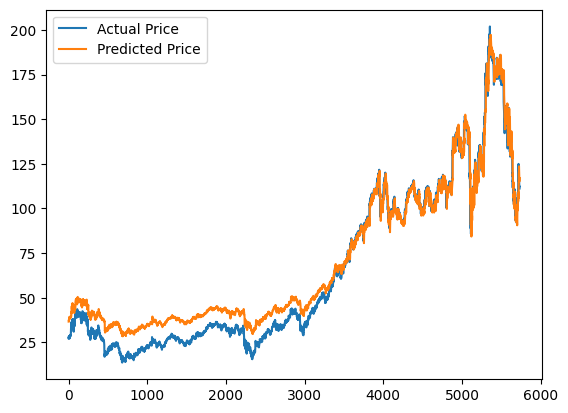

In [35]:
predict_and_save('DIS', api_key, model)